# **Final report**

## Team member  49:

FOURNIER Cédric 

AELLEN Edgar 

FERRARA Elisa

GMÜR Simon Julien


# 0. Environment

### ArUco 

To begin with, we use ArUco barcodes to identify 3 elements through the camera. 

##### 1) The map reference : 
We place 4 defined ArUco at the corners of the map that we want to model with a matrix. 

##### 2) The robot reference :
We place an ArUco directly on the Thymio to locate the robot's position continuously with the camera. 

##### 3) The goal reference :
A final ArUco is used to define the goal the robot must reach.

### Obstacles

There are two types of obstacle in the project: global obstacles, which can be detected by the camera, and local obstacles, which will be detected by the Thymio's distance sensors.

##### 1) Global obstacles :
For global obstacles, we use tangerines, firstly because we're in the tangerine season and secondly, their orange color makes them easy to spot. As a result, they contrast well with the ground we're using. We also use tangerine peels to "flatten" global obstacles and make them invisible to proximity sensors.

##### 2) Local obstacles : 
For local obstacles, we use a silver gourd or any other rounded object to make it easier for the robot to get around. The silver color ensures good reflection and greater precision with IR sensors.

### Map types

In our project, we can use any kind of map possible, as long as it's a different color from the global obstacles. Specifically, we're going to use the CO building's carpet as a map, as it contrasts well with our obstacles.

### Pictures

Here is a picture, of a common set of use for our thymio :

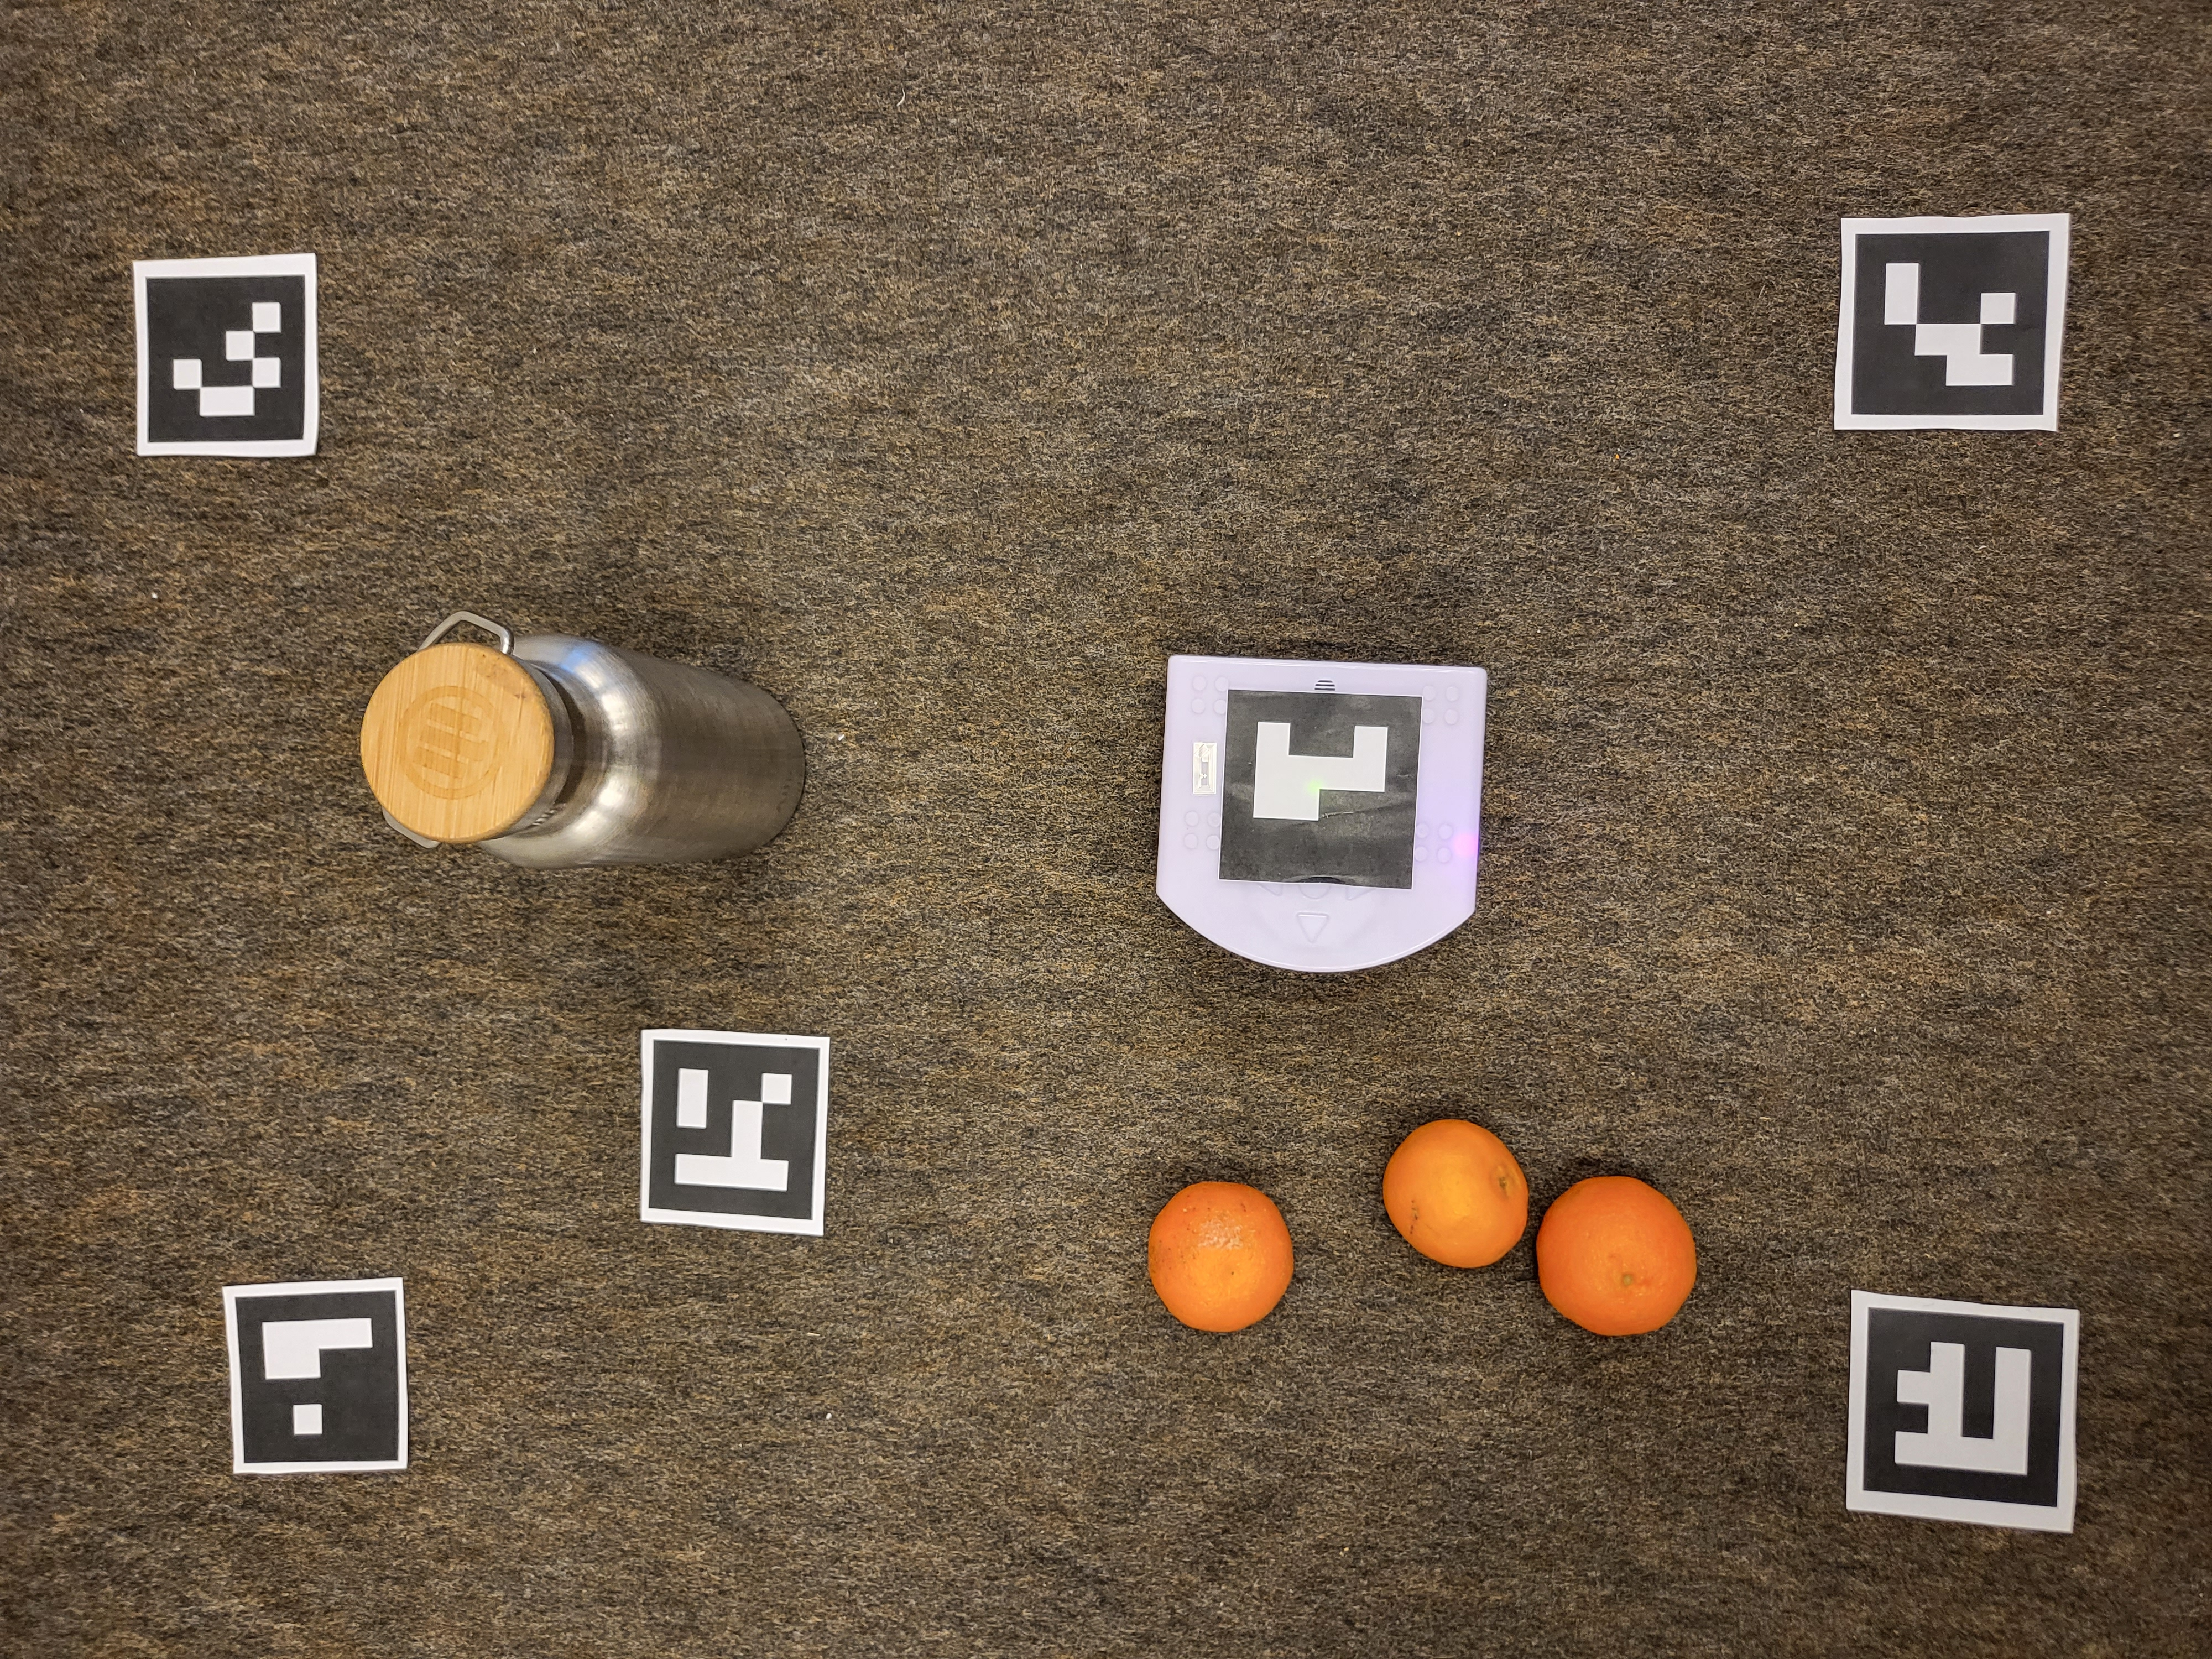


# 1. COMPUTER VISION

The aim of the computer vision is to detect the Thymio robot, its goal and their respective positions. To detect the different known objects on the frames of the camera, we use the ArUco marker library. To each object is assigned an id from a dictionnary corresponding to a marker. A marker is a an array of black and white pixels. As for the obstacles, we prefer to rely on color detection. This technique is more flexible as it doesn't require to give a marker to each obstacle and enable us to obtain the contours of the areas in the image with a specific pixel color.

To localize the objects in the space, a map is built. This map requires three references with known positions. If these three references are detected on the image we can use the map to localize the others detected objects. We can print the map in a matrix format with the obstacles, the robot and the goal represented on it. As we realized the angle of the camera introduce a slight error in the calculus of the position and orientation of the objects. So, we add a fourth reference to correct the distortion of the image. A transformation matrix is built by comparison between the detected positions of the references in the image and their known positions. This transformation matrix can then be applied to the complete image or 

<figure>
    <img src="img_cam.png" alt="Original Image" height="270">
    <img src="img_cor.png" alt="Mask" height="270">
    <img src="img_map.png" alt="Obstacles" height="270">
    <figcaption>From left to right: Original image, Corrected image, Resulting Map</figcaption>
</figure>



## ArUco marker detection

The marker detection algorithm provides a list of the identified markers in the image with for each marker its corners positions and its ID in the source dictionnary.
The marker detection process unfolds in two steps:

1. Detection of Marker Candidates through adaptive thresholding to segment potential markers within the image. The contours are extracted from the thresholded image and only those approximating square shapes and exhibiting convex characteristics are kept. Additional filtering with contours elimination based on size criteria and spatial proximity are performed.
    
2. Marker Codification Analysis: The algorithm verifies each markers candidates by scrutinizing their inner codification. It uses a perspective transformation to acquire the marker in its canonical form and thresholds the canonical image using Otsu's method to distinguish white and black bits. Then, it divides the image into cells based on marker and border sizes, counting black and white pixels in each cell. Finally, it analyzes the bits, determining if they align with the markers in the specified dictionary.

In summary, the marker detection process of the ArUco library combines candidate identification and codification analysis to reliably recognize and characterize ArUco markers in images, providing crucial positional information and unique identifiers.

References : https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html


In [ ]:
# Create an ArucoDetector given a specific dictionary
def create_detector(dictionary):
    # Create a detector
    parameters = cv2.aruco.DetectorParameters()
    parameters.adaptiveThreshWinSizeMin = 10
    parameters.adaptiveThreshWinSizeMax = 500
    parameters.adaptiveThreshWinSizeStep = 10
    # Set the minimum distance tolerated between a marker and the border of the image
    parameters.minDistanceToBorder = 0
    
    detector = cv2.aruco.ArucoDetector(dictionary, parameters)
    return detector

############################################################################################################################################
# Detect given objects on a given frame with a given detector. 
# Update the image positions and corners of the objects. 
def detect_objects(frame, detector, objects):
    corners = np.array([[]])
    corners, ids, _ = detector.detectMarkers(frame)
    for o in range(np.size(objects,0)):
        centers = []
        c = []
        if np.size(corners,0) > 0:
            for i in range(np.size(ids,0)):
                if objects[o].id == ids[i][0]:
                    centers.append(get_center(corners[i][0]))
                    c.append(corners[i][0])
        objects[o].img_pos = np.array(centers)
        objects[o].corners = np.array(c)
    return


## Color recognition

For the obstacle detection, a example image of an obstacle is taken. The mean and standard deviation of the color of the obstacle image is calculated. A mask is then created, by selecting the pixels of the original image within a range of two standard deviation from the mean color of the obstacle. The areas of the mask too small to indicate an obstacle are then filtered.

<figure>
    <img src="obs.png" alt="Original Image" height="300">
    <img src="mask.png" alt="Mask" height="300">
    <img src="obs_detected.png" alt="Obstacles" height="300">
    <figcaption>From left to right: Original image, Mask, Obstacles</figcaption>
</figure>

# 2. GLOBAL PATH PLANNING

## a. Algorithm A*

For the global path, we decided to opt for the A* algorithm to compute our optimal route. Indeed, the algorithm's calculations provide us with very good accuracy. However, it's quite slow to compute, especially when dealing with a large map or when creating a circuit where the path is long. For the A* algorithm, we based our implementation on the one presented in the course by Professor Mondada Francesco. Nevertheless, we made several modifications, such as enabling the handling of rectangular matrices and adding a function to expand obstacles in the matrix, allowing the robot to maneuver around them. Here is the general code of our global.

In [4]:
# Overall call with input: matrix and output: path, without displaying
def global_path(matrix):
    
    max_val_x, max_val_y, start, end, original_grid = conversion(matrix)

    # Grow the obstacles in the matrix
    growth_size = 7 # size of robot radius (in grid dimension) (would be 5.5cm)
    occupancy_grid, obstacle_indices = grow_obstacles(original_grid, growth_size)

    # Calling A*
    h, coords = heuristics(max_val_x, max_val_y, end)
    path, visitedNodes = A_Star(start, end, h, coords, occupancy_grid, max_val_x, max_val_y)
    path = np.array(path).reshape(-1, 2).transpose()
    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
    
    return path, visitedNodes, occupancy_grid, obstacle_indices

## b. Growth obstacles
This function aims to enlarge the size of objects detected by the camera, allowing the robot to navigate around them. As the A* algorithm calculates the optimal path by considering the robot's center, it's possible that it could run along global obstacles. The risk is that without a safety margin of at least half a Thymio's width, the robot might collide with the obstacle. Here is the code that implement this.



In [5]:
# Grow the obstacles to avoid collision
def grow_obstacles(matrix, growth_size):
    
    # Matrix to a numpy array (in case not already)
    arr = np.array(matrix)

    # New matrix with the same shape and filled with zeros
    expanded_matrix = np.zeros_like(arr)

    # Find the indices of obstacles (value = 1) in the original matrix
    obstacle_indices = np.where(arr == 1)

    # Grow obstacles in the expanded matrix
    for i, j in zip(obstacle_indices[0], obstacle_indices[1]):
        
        # Range for the expanded obstacles
        row_range = slice(max(0, i - growth_size), min(arr.shape[0], i + growth_size + 1))
        col_range = slice(max(0, j - growth_size), min(arr.shape[1], j + growth_size + 1))

        # Setting the corresponding elements to 1 in expanded matrix
        expanded_matrix[row_range, col_range] = 1

    return expanded_matrix, obstacle_indices


## c. Problem with A* and keypoints
Despite the numerous advantages of A*, we encountered significant issues. Firstly, the computation time sometimes reached 1 to 2 minutes depending on the maps, significantly slowing down robot testing. Secondly, initially, we wanted the robot to pass through every point in the path given by the algorithm. However, this approach forced the robot to move very slowly (especially with a matrix having 1cm cells), risking missing a cell and potentially reversing to validate it. We attempted to increase the area around the robot and reduce its speed to validate the points, but this didn't yield better results. Hence, we opted to switch to a keypoints method.

Upon observing that the graph generated by path calculation often contained many sequentially aligned points, we devised a keypoints approach. We developed a function that traverses the entire graph, recording only the points where an angle between 3 points is formed. These points constitute a list of keypoints that the robot should follow to reach its goal. This method reduced the path size by approximately 90% to 95%, enabling us to increase the Thymio's speed and grant more flexibility.

However, we encountered another issue. When the global path produced a "staircase" pattern, it generated numerous keypoints. To address this, we introduced a modulo operation to select only one keypoint for every modulo cells. For instance, even if the subsequent point was also a keypoint, it wouldn't be considered. The risk with this method is potentially missing an important keypoint within a staircase-like path. Here is the function we use to calculate the keypoints along the path

In [6]:
#This function is to select only the keypoint of the path
def calculate_angles_along_path(path):
    key_points = [[], []]
    angle_TH = 45
    x_coords, y_coords = path[0], path[1]
    path_length = len(x_coords)

    if path_length < 3 or len(y_coords) != path_length:
        print("Invalid path format.")
        return angles

    for i in range(path_length - 2):
        if i % 10 == 0:
            kpoint = True
        point_A = [x_coords[i], y_coords[i]]
        point_B = [x_coords[i + 1], y_coords[i + 1]]
        point_C = [x_coords[i + 2], y_coords[i + 2]]

        angle_at_point = calculate_angle(point_A, point_B, point_C)
        if(angle_at_point > angle_TH) and kpoint == True:
            key_points[0].append(point_B[0])
            key_points[1].append(point_B[1])
            kpoint = False
    
    #We add the last point of the path as a Key point          
    key_points[0].append(x_coords[-1])
    key_points[1].append(y_coords[-1])
            
            
    return key_points

# 3. LOCAL OBSTACLE AVOIDANCE

## a. Potential field

To avoid local obstacles, we've opted for the potential field technique, which allows the Thymio to be repelled by obstacles and attracted by a keypoint, i.e. a local target. The Thymio will then move to the right or left of the object, depending on its proximity sensors. It will therefore not come into contact with the obstacle. In the function below, by repeating a scenario over and over again, we've established the most suitable weights for our Thymio in the obstSpeedGain variable. These weights are used to adjust the robot's speed away from the local obstacle. Then, in the same scenario, we tested several times the thresholds to be reached to activate local mode or remain in global mode. These thresholds are found in the constants obstThrL and obstThrH constants. We've chosen to keep them small, in order to avoid the bypass problem. Here's the local function we use to avoid obstacles:


In [7]:
#Global variables of the local function
obstThrL = 500     
obstThrH = 1200
spRight = 0
spLeft = 0
speed_L_R = [0,0]
obstSpeedGain =  [2, 6, -15, -8, -4] 


def local_navigation(obst,speed0):
    
    spLeft = speed0
    spRight = speed0
    for i in range(5):
        spLeft += obst[i] * obstSpeedGain[i] // 100
        spRight += obst[i] * obstSpeedGain[4 - i] // 100
    speed_L_R = [spLeft,spRight]
    
    return speed_L_R


## b. Bypass problem

The issue with bypassing lies in the fact that when the robot circumvents a local obstacle, if the keypoint is situated beneath or closely behind the obstacle, it will circle around the obstacle while trying to reach its keypoint. By avoiding the obstacle, the Thymio will return to the global mode and hence redirect itself toward the keypoint. Consequently, the circumvention cannot be performed correctly. To address this problem, we considered several solutions, such as recalculating a global path each time the local mode is exited, or increasing the threshold of points so that even if we avoid the points, we 'consider' that we have passed over the key point. However, none of these methods were convincing. Here is a scheme that show the problem :

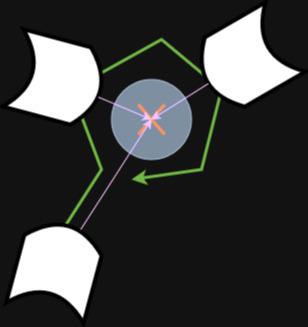

CAPTIONS : 

White : Thymio / Green : Movment of the thymio / Orange : Keypoint / Blue : Local obstacle / Pink : Direction of the keypoint


## c. Bypass Solution

To solve this issue, we have opted for a geometric solution. Indeed, when the Thymio exits the local mode, it will execute an algorithm that determines the next keypoint it should follow to avoid running into the obstacle again. For this, we can break down the algorithm into several different steps:

##### 1) Get the position of the robot :

To run this algorithm, we need to get the position of the robot. To do this, we first check the status of the camera to determine whether we can take its position directly or if we need to pass it through the Kalman filter.

##### 2) Closest keypoint compute + angle :

In this second part, we calculate the distance to the nearest keypoint from the robot, and then compute the angle between the robot's direction and the vector connecting the nearest keypoint to the robot's center.

##### 3) Condition of the algorithm  :

In the third part, we check if the previously calculated angle is smaller than a chosen value, which after several trials, has been set at 50°. If the angle is larger, we repeat the operation from part 2 with the next nearest keypoint, and so on. If no keypoint is found, we take the goal as the last keypoint.

######  Possibility and more deep problem

If a keypoint is found with a smaller angle, it means it lies within approximately ±50° of the robot's direction, preventing it from circling around the obstacle. When a keypoint is below the object, the robot deviates from its trajectory due to the proximity sensor, altering its orientation and inadvertently creating an angle with the keypoint under the obstacle. That's why we assigned significant weights to the proximity sensors and set a low threshold to ensure the robot gets as close as possible to the object, enhancing the performance of our algorithm.

If it doesn't find any keypoint meeting this condition, it will consider the goal as the final keypoint and navigate towards it.
In this case, it is reasonably certain that there are no global obstacles between the robot and the goal.

However, the algorithm has some flaws that we couldn't resolve. The first one is that if the object is very large (for instance, a rectangle), the robot will still manage to avoid the object, but it will take time and it will alternate several times between local and global modes. Moreover, if the object is placed near the goal and there are no more keypoints, it will be challenging for the Thymio to reach its destination. Lastly, in specific cases, the Thymio may consider the goal as the final objective and pass through global obstacles. One solution to this could be to recalculate a global path.

Here is a scheme that show the solution :


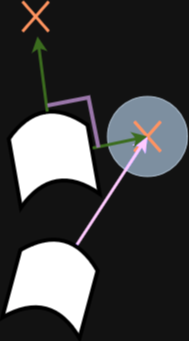

CAPTIONS :

White : Thymio /  Orange : Keypoint /  Blue : Local obstacle / Green : Direction of the thymio and vector between keypoint and thymio / Purple : Angle between direction and vector, here for example 90° so the thymio go to the next keypoint

In [8]:
    #ALL THE FUNCTION USED IN THIS PART, THAT HAVE NOT A PREFIX ARE LOCATES IN THE GLOBAL_NAV.py FILES !
    
    if state == 2:  # Local navigation state
        
        #This part is where we run the Potential field method
        memory_speed = mctrl.memory_speed(vr,vl)
        prox_horizontal = local.read_prox_sensors(node,client)
        obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
        motors_speed = local.local_navigation(obst,speed0)
        mctrl.set_motors(motors_speed[0],motors_speed[1],node)       
        state = local.update_state(state,obst,client)
       

        #When we quit the local state, we enter in this condition to do all the measurements needed to see if we
        #skip the next keypoint or not
        if state == 1:
            #1ST PART
            #Here we get the robot position from the camera if the camera is open
            if np.size(map.localize(thymio), 0) > 0:
                z_k_observation_vector = np.array([map.localize(thymio)[0][0],map.localize(thymio)[0][1],-vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0]))])
                state_estimate_k,P_k_minus_1 = kfil.ekf(z_k_observation_vector, state_estimate_k, control_vector_k_minus_1, P_k_minus_1, Ts, camera_obstructed)
          
            #Or we take the robot position by the kalman filter
            else:
                camera_obstructed = 1
                z_k_observation_vector = np.array([0,0,0])
                state_estimate_k,P_k_minus_1 = kfil.ekf(z_k_observation_vector, state_estimate_k, control_vector_k_minus_1, P_k_minus_1, Ts, camera_obstructed) 
            
            #2nd PART
            #Then, we calculate the closest keypoint and the angle between the keypoint and the robot direction
            closest_index = find_closest_keypoint_index(state_estimate_k[:2], key_points)
            angle = calculate_angle_between_robot_and_closest(state_estimate_k[:2], key_points, closest_index)
            length_of_keypoints = len(key_points[0]) - 1
            
            #3rd PART
            #If the angle between the keypoint and the robot direction is over 50° we look for the next closest keypoint
            #that has an angle of less than 50° and we repeat it until we find the right keypoint
            while abs(angle) > 50:
                if length_of_keypoints > 1:
                    distances = calculate_distances_to_keypoints(state_estimate_k[:2], key_points)
                    next_closest_index = find_next_closest_keypoint(state_estimate_k[:2], key_points, distances, closest_index)
                    closest_index = next_closest_index
                    angle = calculate_angle_between_robot_and_closest(state_estimate_k[:2], key_points, closest_index)
                    length_of_keypoints = length_of_keypoints - 1
               
                #If there is no such keypoint, we just take the goal as keypoint.
                else:
                    closest_index = length_of_keypoints
                    break
            
            #Here we set the new speed to the motors to follow the new keypoint
            closest_keypoint = [[key_points[0][closest_index]],[key_points[1][closest_index]]]
            [vr_glob, vl_glob] = mctrl.return_memory_speed(memory_speed)
            vr, vl = mctrl.control_law(state_estimate_k, closest_keypoint[0], closest_keypoint[1],speed0,speedGain)
            mctrl.set_motors((vl+vl_glob),(vr+vr_glob),node)
            client.sleep(0.7)
            


NameError: name 'state' is not defined

# 4. KALMAN FILTERING FOR POSITION ESTIMATION
## a. Kalman Filter state space model

main source used: https://automaticaddison.com/how-to-derive-the-state-space-model-for-a-mobile-robot/

A state space model, also known as a state transition model, is a formula that describes how a robot moves from one point in time to the next. It illustrates the way a robot's location (such as its X and Y coordinates) and its direction (or yaw, represented by the angle $theta$) are influenced by adjustments to its control inputs.

We chosed to use $\begin{bmatrix} x \\ y \\ \theta \end{bmatrix}$ as the state vector for our differential drive robot. This are infact the quantities that the camera will be able to give us. The vectors refer to the global fixed reference and $theta$ is the angle with the positive direction of the x-axis. Since the only input is the velocity of the two wheels, the systems evolves accordingly to the following equatrions:

$$
\begin{bmatrix}
x_t \\
y_t \\
\theta_t
\end{bmatrix}
=

\begin{bmatrix}
x_{\text{k+1}} + Ts \cdot R \cdot (\frac{v_r+v_l}{2})\cdot \cos(\theta_k)\\
y_{\text{k+1}} + Ts \cdot R \cdot (\frac{v_r+v_l}{2})\cdot \sin(\theta_k)\\
\theta_{\text{k+1}}= Ts \cdot R \cdot (\frac{v_r-v_l}{L})
\end{bmatrix}
=
\begin{bmatrix}
f_1 \\
f_2 \\
f_3
\end{bmatrix}
$$
The inputs considered are the ones taht we use to control it: $v$ and $\omega$, respectvely linear and angular velocity of the robot. The linear velociy has as direction the one indicated by the angle $\theta$. The controller will use hese quantities to execute the path following.
We then linearize in order to obtain a linearized state space model:

$$
A_{t-1} =
\begin{bmatrix}
\frac{\partial f_1}{\partial x_{t-1}} & \frac{\partial f_1}{\partial y_{t-1}} & \frac{\partial f_1}{\partial \theta_{t-1}} \\
\frac{\partial f_2}{\partial x_{t-1}} & \frac{\partial f_2}{\partial y_{t-1}} & \frac{\partial f_2}{\partial \theta_{t-1}} \\
\frac{\partial f_3}{\partial x_{t-1}} & \frac{\partial f_3}{\partial y_{t-1}} & \frac{\partial f_3}{\partial \theta_{t-1}}
\end{bmatrix}
$$


Matrix A relates the states of two consecutive sample is consequently an identity of the same dimension as the state. This is also the result of the above calculations since every function f_i depends linearly and with an unitary coefficient from the corrispondent variable:
$$ A = \begin{bmatrix} 1& 0 & 0\\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} $$

Same thing we did about B matrix considering three partial derivatives with respect to velocity and angular velocity:

$$
B_{t-1} =
\begin{bmatrix}
\frac{\partial f_1}{\partial v_{t-1}} & \frac{\partial f_1}{\partial \omega_{t-1}} \\
\frac{\partial f_2}{\partial v_{t-1}} & \frac{\partial f_2}{\partial \omega_{t-1}} \\
\frac{\partial f_3}{\partial v_{t-1}} & \frac{\partial f_3}{\partial \omega_{t-1}}
\end{bmatrix}
$$


and so:

$$
B_{t-1} =
\begin{bmatrix}
Ts(\frac{R}{2})\cos \theta_{t-1} & Ts(\frac{R}{2})\cos \theta_{t-1}  \\
Ts(\frac{R}{2})\cos \theta_{t-1} & Ts(\frac{R}{2})\cos \theta_{t-1} \\
\frac{R\cdot Ts}{L} & -\frac{R\cdot Ts}{L}
\end{bmatrix}
$$

Finally, we added a process noise w with a Gaussian distribution with zero mean and covariance Q:
$$
\begin{bmatrix}
x_t \\
y_t \\
\theta_t
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
x_{t-1} \\
y_{t-1} \\
\theta_{t-1}
\end{bmatrix}
+
\begin{bmatrix}
Ts(\frac{R}{2})\cos \theta_{t-1} & Ts(\frac{R}{2})\cos \theta_{t-1}  \\
Ts(\frac{R}{2})\cos \theta_{t-1} & Ts(\frac{R}{2})\cos \theta_{t-1} \\
\frac{R\cdot Ts}{L} & -\frac{R\cdot Ts}{L}
\end{bmatrix}

\begin{bmatrix}
vr_{t-1}\\
vl_{t-1}
\end{bmatrix}
+
\begin{bmatrix}
w_{x_{t-1}} \\
w_{y_{t-1}} \\
w_{\theta_{t-1}}
\end{bmatrix}
$$


## b. Kalman Filter observation model
The observation model consists in predicting sensor measurements based on the estimated or predicted state of the system at the next timestep. Instead of directly translating raw sensor data into a state estimate, this model uses the current state prediction to forecast what the sensors should detect, creating a basis for comparison with actual sensor readings.
The observation model works by first using the state model to predict the state of the robot at that next timestep and then using that state prediction to infer what the sensor measurement would be at that point in time. 
This allows to then compute a weighted average (Kalman Filtering) of the predicted sensor measurements and the actual sensor observation at that timestep to create a better estimate of your state.

The measurements we obtain are the ones coming from the camera: position in terms of (x,y) coordinates and orientation ($\theta$ angle).
The general equation for the observation model is the following:
$$
y_t = H\cdot
\begin{bmatrix}
x\\
y\\
\theta
\end{bmatrix}
+
\begin{bmatrix}
v_{x_{t-1}} \\
v_{y_{t-1}} \\
v_{\theta_{t-1}}
\end{bmatrix}
$$

v is the measurement noise gaussianly distributed with zero mean and covariance matrix R.
The measurement matrix H is used to convert the predicted state estimate at time t into predicted sensor measurements at time t. In our case, H will be the identity matrix since the estimated state maps directly to sensor measurements [x, y, $\theta$]:
$$
H = 
\begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}


## c. Kalman Filter actual implementation
code derived from: https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example/ 
code in Kal_FILTER.py

**Parameters choices**
*------------------------------------------------Q matrix: covariance matrix of process noise---------------------------------------------------------------------*

Given out 3-dimensional state $ \begin{bmatrix}
x  \\
y  \\
\theta
\end{bmatrix} $, the corresponding Q covariance matrix for the noise has the following structure:

$$ Q_k = \begin{bmatrix}
\text{Var}(x) & \text{Cov}(x,y) & \text{Cov}(x,\theta) \\
\text{Cov}(y,x) & \text{Var}(y) & \text{Cov}(y,\theta) \\
\text{Cov}(\theta,x) & \text{Cov}(\theta,y) & \text{Var}(\theta)
\end{bmatrix} $$


(consulted material: https://www.ucl.ac.uk/~ucfbpve/geotopes/indexch10.html) 

A measurement of the state is not available and we don't have any accurate sensors to do it. The way we chose to calculate Q related to the process relates to the Error Propagation Formula that relates the variance and covariance of a variable that depends upon other to the variances of the latters. \
In general, if $ t = f(X, Y)$

$$
\sigma^2_t = \begin{bmatrix}
\frac{\partial t}{\partial X} & \frac{\partial t}{\partial Y}
\end{bmatrix}
\begin{bmatrix}
\sigma^2_X & \text{cov}(X, Y) \\
\text{cov}(X, Y) & \sigma^2_Y
\end{bmatrix}
\begin{bmatrix}
\frac{\partial t}{\partial X} \\
\frac{\partial t}{\partial Y}
\end{bmatrix}
$$

In our case, the state space model we used toghether with the functions relating the inputs $v$ and $\omega$ to $v_r$ and $v_l$ give us the following discrete time relations:

$$
x_k=x_{\text{k+1}} + Ts \cdot R \cdot (\frac{v_r+v_l}{2})\cdot \cos(\theta_k) = f_1\\
y_k= y_{\text{k+1}} + Ts \cdot R \cdot (\frac{v_r+v_l}{2})\cdot \sin(\theta_k)= f_2\\
\theta_k=\theta_{\text{k+1}}= Ts \cdot R \cdot (\frac{v_r-v_l}{L}) = f_3
$$
where R represents the radius of the wheels and L the distance between them.




We can derive the following formulas:



**VARIANCE ESTIMATION**
$$ \sigma_x^2 = \left( \frac{\partial f_1}{\partial v_r} \right)^2 \sigma_{v_r}^2 + \left( \frac{\partial f_1}{\partial v_l} \right)^2 \sigma_{v_l}^2 + 2 \left( \frac{\partial f_1}{\partial v_r} \right) \left( \frac{\partial f_1}{\partial v_l} \right) \text{Cov}(v_r, v_l) $$

$$ \sigma_y^2 = \left( \frac{\partial f_2}{\partial v_r} \right)^2 \sigma_{v_r}^2 + \left( \frac{\partial f_2}{\partial v_l} \right)^2 \sigma_{v_l}^2 + 2 \left( \frac{\partial f_2}{\partial v_r} \right) \left( \frac{\partial f_2}{\partial v_l} \right) \text{Cov}(v_r, v_l) $$

$$ \sigma_\theta^2 = \left( \frac{\partial f_3}{\partial v_r} \right)^2 \sigma_{v_r}^2 + \left( \frac{\partial f_3}{\partial v_l} \right)^2 \sigma_{v_l}^2 + 2 \left( \frac{\partial f_3}{\partial v_r} \right) \left( \frac{\partial f_3}{\partial v_l} \right) \text{Cov}(v_r, v_l) $$

Since we can consider than the speeds on the two wheels are indipendent one on the other their covarianc is null:

$$\sigma_x^2 =  (\frac{Ts\cdot R}{2} \cos(\theta))^2 \cdot (\sigma_{V_r}^2+ \sigma_{V_l}^2)$$ 
$$\sigma_y^2 = (\frac{Ts\cdot R}{2} \sin(\theta))^2 \cdot (\sigma_{V_r}^2+\sigma_{V_r}^2)$$ 
$$\sigma_\theta^2 =  (\frac{Ts\cdot R}{L})^2 \cdot(\sigma_{V_r}^2+\sigma_{V_r}^2)$$


**COVARIANCE ESTIMATION**
$$
\text{Cov}(x, y) = \left( \frac{\partial f_1}{\partial v_r} \frac{\partial f_2}{\partial v_r} \right) \text{Var}(v_r) + \left( \frac{\partial f_1}{\partial v_l} \frac{\partial f_2}{\partial v_l} \right) \text{Var}(v_l) + \left( \frac{\partial f_1}{\partial v_r} \frac{\partial f_2}{\partial v_l} + \frac{\partial f_1}{\partial v_l} \frac{\partial f_2}{\partial v_r} \right) \text{Cov}(v_r, v_l)
$$

$$
\text{Cov}(x, \theta) = \left( \frac{\partial f_1}{\partial v_r} \frac{\partial f_3}{\partial v_r} \right) \text{Var}(v_r) + \left( \frac{\partial f_1}{\partial v_l} \frac{\partial f_3}{\partial v_l} \right) \text{Var}(v_l) + \left( \frac{\partial f_1}{\partial v_r} \frac{\partial f_3}{\partial v_l} + \frac{\partial f_1}{\partial v_l} \frac{\partial f_3}{\partial v_r} \right) \text{Cov}(v_r, v_l)
$$

$$
\text{Cov}(y, \theta) = \left( \frac{\partial f_2}{\partial v_r} \frac{\partial f_3}{\partial v_r} \right) \text{Var}(v_r) + \left( \frac{\partial f_2}{\partial v_l} \frac{\partial f_3}{\partial v_l} \right) \text{Var}(v_l) + \left( \frac{\partial f_2}{\partial v_r} \frac{\partial f_3}{\partial v_l} + \frac{\partial f_2}{\partial v_l} \frac{\partial f_3}{\partial v_r} \right) \text{Cov}(v_r, v_l)
$$

Hence,

$$
\text{Cov}(x, y) = (\frac{R}{2}\cdot Ts)^2 (\cos(\theta) \sin(\theta))(Var(v_r) + Var(v_l))\\

\text{Cov}(x, \theta) = \frac{(Ts\cdot R)^2}{2L} \cos(\theta)  (Var(v_r) - Var(v_l))\\

\text{Cov}(y, \theta) = \frac{(Ts\cdot R)^2}{2L} \sin(\theta) (Var(v_r) - Var(v_l))
$$
The covariance matrix is always symmetric.


From testing we measured the velocities of the two wheels as in the following graph:
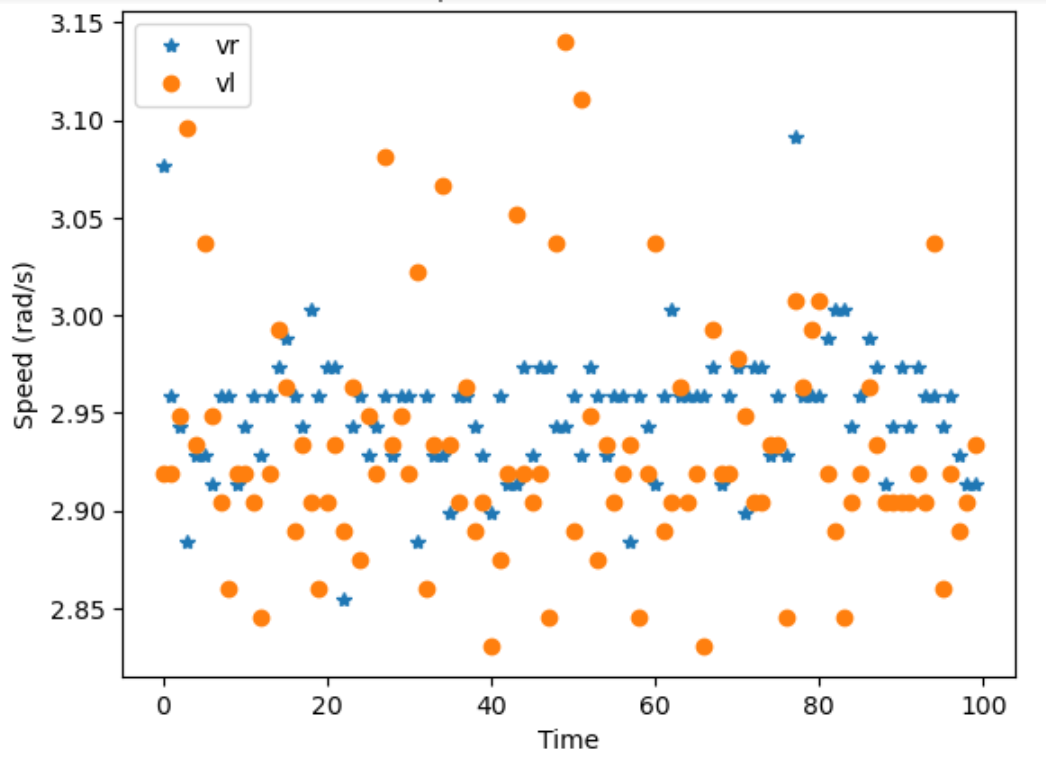

Then from the formulas of covariance and variance above, we calculated the entries of Q matrix for various angles:
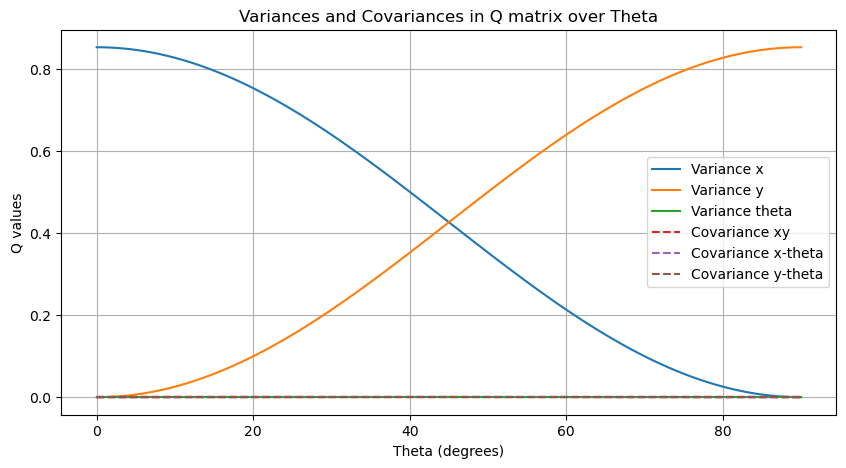

From the graph we can see that:
1. The covariances between theta and the other two variables are always negligible: these value depend in fact on the difference of the variance of the speed of the two wheels. Being it quasi-identical the two values fall down to zero.
2. Covariance between x and y is neglectible. In the mathematica formula we can in fact observe that the same function of $\theta$ is multiplied in this case by the same coefficient that in the variances of x and y but in this case in the denominator there is L which reduces the magnitude of teh coefficient. Moreover, the coefficient, smaller that 1, is also to thw second power and so it is further reduced.
3. Variance of theta is really smaller, quasi-null if compared to the variances of the other state variables. This is due againg to the coefficient which is smaller. 

Finally, we demonstrated that the covariance matrix of the process is diagonal.
Kalman Filter has as an assumption that Q matrix is not depedent on the state. We decided to use tha maximum value for each variance and covariance in order to never overestimate the capabilities of the state predictions.

$$
Q= 
\begin{bmatrix}
0.85382 & 0 & 0\\
0 & 0.85382 & 0\\
0 &0 & 0.00032
\end{bmatrix}
$$


*-----------------------------------------------R matrix: covariance matrix of measurement noise----------------------------------------------------------------*
**TODO**

*-----------------------------------------------Convertion factors for wheels velocities-------------------------------------------------------------------------*


The goal is to convert the velocity of rotation of the wheels units from rad/s to the Thymio ones. Controller in fact will have as an input $v_r$ and $v_l$ in rad/s but will output them in Thymio Units to the plant.

<table><tr> 
<td> <img src="photo_2023-11-23_20-33-54.jpg" alt="photo_2023-11-23_20-33-54" style="width: 250px;"/> </td> 
 
</tr></table>

We used a code that counts the time untill one presses the central button. So, one person counts a certain amount of rounds and sign the number counted in the variable num_rotations. Then with some simple counts given the number of rotations and the time needed to do it, the velocity of rotation is calculated. The final coefficient is the average of the coefficients extracted.
In order to actually count the number of rounds we drew a green mark on the wheel.

The results are summarized in the following picture:
![Alt text](image.png)

*----------------------------------------------- Velocity conversion: from $v_r$ and $v_l$ to $v$ and $\omega$------------------------------------------------------*
https://www.cs.columbia.edu/~allen/F17/NOTES/icckinematics.pdf 

Linear velocity is the average of the speeds of the two wheels.
$ v = R\cdot \frac{v_{\text{r}} + v_{\text{l}}}{2}  $

Angular velocity depends on the difference in speed of the two wheels and the distance between them (wheelbase). If L is the distance between the centers of the two wheels, then:
$\omega = R \cdot\frac{v_{\text{r}} - v_{\text{l}}}{L} $ 


Given that we obtain:

$v_{r} = \frac{2v+\omega L}{2R}$ ,

$v_{l} = \frac{2v-\omega L}{2R}$

Consult the python code of the controller for the detailed definition of these functions


# 5. Motion Control

In our motion control system, we employed a P controller to manage and regulate the robot's movement. The P controller, short for Proportional controller, is a fundamental type of feedback control mechanism. It operates by computing an output proportional to the current error - the difference between the desired state and the actual state of the system. Here is the code we use for the controller :

In [9]:
def control_law(state_estimate_k, x_goal, y_goal, speed0, speedGain):
     
    orient_goal = math.atan2(y_goal - state_estimate_k[1], x_goal - state_estimate_k[0])
    delta_angle = orient_goal - state_estimate_k[2]

    if abs(delta_angle) > 0.8:
        vr = int(speedGain * delta_angle)
        vl = int(-speedGain * delta_angle)
    else:
        vr = int(speed0 + speedGain * delta_angle)
        vl = int(speed0 - speedGain * delta_angle)
        
    return vr, vl

# 6. References

## Global Navigation :

A* algorithm, code and plot function : Solutions for exercise session 5 from moodle course Basics of mobile 


## Local Navigation :

Potential field algortihm and code: Solutions for exercise session 4 (updated 10/10/2023) from moodle course Basics of mobile robotics

## Kalman module :

Kalman filer state space model :

(main source) : https://automaticaddison.com/how-to-derive-the-state-space-model-for-a-mobile-robot/

Kalman Filter actual implementation : 

(code derived) :  https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example/

(consulted material) : https://www.ucl.ac.uk/~ucfbpve/geotopes/indexch10.html

(velocity conversion) : https://www.cs.columbia.edu/~allen/F17/NOTES/icckinematics.pdf





In [10]:
#Global variables
state = 0
obst = [0,0,0,0,0]
motors_speed = [0,0]
not_arrived = True
k = 0
C_conv_toThymio_right = 67.60908181
C_conv_toThymio_left = 67.82946137
L = 95 #mm
R = 23 #mm
Ts = 0.5 # sampling time
# Initial state covariance matrix
P_k_minus_1 = np.array([[0.1, 0, 0],
                        [0, 0.1, 0],
                        [0, 0, 0.1]])
P_k = P_k_minus_1
threshold_for_convergence = 20
threshold_for_convergence_local = 100
speed0 = 60
speedGain = 30

path = []
while True:
    if state == 0:
        # Create an adjusted dictionary of 5 markers of 4x4 bits.
        aruco_dictionary = cv2.aruco.extendDictionary(5, 4)
        # Assign a marker to each objects to be recognized on the map
        # Generate three reference markers
        detector = create_detector(aruco_dictionary)
       

        for i in range(5):
            marker = cv2.aruco.generateImageMarker(aruco_dictionary, i, 500, np.zeros((6, 6, 1), dtype="uint8"), 1)
            cv2.imwrite('marker' + str(i) +'.jpg', marker)
        # Definition of the references used to map the space
        ref1 = Obj(0, np.array([[0,0]]))
        ref2 = Obj(1, np.array([[0,0]]))
        ref3 = Obj(2, np.array([[0,0]]))

       
        # Definition of the objects to recognize in the space
        goal = Obj(3, np.array([[]]))
        thymio = Obj(4, np.array([[]]))

        map = Map(ref1,ref2,ref3,920,660)

        objects = np.array([ref1,ref2, ref3, goal, thymio])

        # Open the video
        # For a livestream
        video = cv2.VideoCapture(0)
        # or with a prerecorded video
        #video = cv2.VideoCapture('test3.avi')
        if (video.isOpened()== False): 
            print("Error opening video stream or file")
        
        # Recognition of the view with the map and path planning
        path_found = False
        while not (path_found):
            ret, frame = video.read()
            if ret == True:
                clear_output(wait=True)
                show_frame(frame)

                detect_objects(frame, detector, objects)
                if map.references_detected():
                    print('Goal position', map.localize(goal))
                    matrix = map.matrix(frame, thymio, goal)

                    if check_matrix(matrix):
                        path, visitedNodes = global_path(matrix)
                        print_path(matrix, path, visitedNodes)
                        path = np.multiply(path, 50)
                        N = np.size(path,1)
                        path_found = True
                        state_estimate_k = np.array([map.localize(thymio)[0][0],map.localize(thymio)[0][1],-vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0]))])

        # Navigation
        state = 1    
        # Global navigation state
    if state == 1:
    
        while not_arrived == True:

            #Check if there is obstacles
            prox_horizontal = local.read_prox_sensors(node,client)
            obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
            state = local.update_state(state,obst,client)
            if state == 2:
                break

            # Path following: control law
            print("Position final goal", [path[0,k],path[1,k]])
            vr, vl = mctrl.control_law(state_estimate_k, path[0,k], path[1,k],speed0,speedGain)
            #control_vector_k_minus_1 = mctrl.convert_velocity2vw(vr,vl,C_conv_toThymio_right, C_conv_toThymio_left,L,R) if we use [v,w] as control variables in state space model
            control_vector_k_minus_1 = np.array([vr/C_conv_toThymio_right,vl/C_conv_toThymio_left]) #if we use [vr,vl] as control variables in state space model
            print("Control vector", control_vector_k_minus_1)
            mctrl.set_motors(vl,vr,node)
            
            
            # Take Thymio position if camera is not obstructed and update state estimate with kalman filter
            if video.isOpened:
                ret, frame = video.read()
                new_frame = frame.copy()
                if ret == True:
                    
                    #clear_output(wait=True)
                    detect_objects(frame, detector, objects)
                    
                    ref1.draw(new_frame, [255,0,0])
                    ref2.draw(new_frame, [0,255,0])
                    ref3.draw(new_frame, [0,0,255])
                    goal.draw(new_frame, [255,255,255])
                    thymio.draw(new_frame, [255,0,0])
                    #show_frame(new_frame)
                    
                    
                    if map.references_detected(): #camera correctly working
                        camera_obstructed = 0

                        if np.size(map.localize(thymio), 0) > 0: #camera working correctly
                            #take robot position from camera
                            z_k_observation_vector = np.array([map.localize(thymio)[0][0],map.localize(thymio)[0][1],-vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0]))])  
                            print("Robot position and angle (rad)", z_k_observation_vector)  
                            # update state estimate with kalman filter
                            #state_estimate_k = z_k_observation_vector #if you don't use kalman filter
                            state_estimate_k,P_k_minus_1 = kfil.ekf(z_k_observation_vector, state_estimate_k, control_vector_k_minus_1, P_k_minus_1, Ts, camera_obstructed)
                            print("State_estimate_k", state_estimate_k)
                            print("temporary goal: ", [path[0,k], path[1,k]])   
                    else: #camera obstructed
                        camera_obstructed = 1
                        print("WARNING:NOCAMERA--WARNING:NOCAMERA--WARNIN:NOCAMERA--WARNING:NOCAMERA")
                        #Measurements are not updated by camera but only by kalman filter
                        state_estimate_k,P_k_minus_1 = kfil.ekf(z_k_observation_vector, state_estimate_k, control_vector_k_minus_1, P_k_minus_1, Ts, camera_obstructed) 
                        print("State_estimate_k", state_estimate_k)
                        print("temporary goal: ", [path[0,k], path[1,k]])

            # Check if the robot has arrived to the temporary goal
            if np.linalg.norm(state_estimate_k[:2] - np.array([path[0,k], path[1,k]])) < threshold_for_convergence:
                if k >= N-1:
                    not_arrived = False
                    print('The robot has arrived to the final goal')
                    mctrl.stop_motors(node)
                    #break

                elif k + N//8 < N-1:
                    k = k + N//8 # go to the next temporary goal 
                else:
                    k = N-1   # go to the final goal
                print("position {} of {} in path: ".format(k,N-1))
                

 
            time.sleep(Ts)   


    # Local navigation state
    if state == 2:         
        #We get the sensor value
        prox_horizontal = local.read_prox_sensors(node,client)
        
        #We fill the obst list with the sensor value
        obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
        
        #We calculate the motor speed to avoid the object -> potential field method
        motors_speed = local.local_navigation(obst)
        
        #We set the motor speed
        mctrl.set_motors(motors_speed[0],motors_speed[1],node)       
        #We update the state
        state = local.update_state(state,obst,client)
        if state == 1:
            vr = speed0
            vl = speed0
            mctrl.set_motors(vl,vr,node)
            if k + 40 < N-1:
                k = k+40
            else: 
                k = N-10
            print("koala")
             
            

       


NameError: name 'np' is not defined

#